# Analysis of Peptide Trajectory

In this notebook, we analyze an all-atom MD simulation of a peptide system in explicit solvent using `MDAnalysis` python pachage. We focus on extracting key structural and dynamic properties relevant for aggregation behavior and peptide phase behavior:

- Backbone RMSD
- Radius of gyration (Rg)
- Peptide-peptide contact frequency
- Diffusion estimation (MSD)
- Cluster size distribution (simple k-means)

Trajectory: 50 ns with 500 ps timestep
System: 100 short disordered peptides in water and ion solution (water and ions are not present in the .xtc file)

In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms, diffusionmap
from MDAnalysis.analysis import distances
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [9]:
sns.set(style="whitegrid")

### Loading the trajectory

In [2]:
u = mda.Universe('../data/initial.pdb','../data/pbc.md.xtc')

In [3]:
# natoms = u.trajectory.n_atoms
nframes = u.trajectory.n_frames
dt = u.trajectory.dt
units = u.trajectory.units
protein = u.select_atoms("protein and not resname ACE and not resname NME") #contains only protein information; here is the same as all atoms
nchains = u.select_atoms('resname ACE and name CH3').n_atoms
natoms = protein.n_atoms
natoms_perchain = int(natoms/nchains)
residues = np.unique(u.residues.resnames)

In [4]:
print("Trjectory of",nframes,"frames of", u.trajectory.totaltime, units['time'], "with a timestep of", dt, units['time'])
print("There is", natoms,"total atoms (", nchains,"chains each of",natoms_perchain,"atoms )")
print("Unique residues ", residues)

Trjectory of 101 frames of 50000.0 ps with a timestep of 500.0 ps
There is 9400 total atoms ( 100 chains each of 94 atoms )
Unique residues  ['ACE' 'GLN' 'GLY' 'NME' 'TYR']


In [5]:
chains = [protein[i*natoms_perchain:(i+1)*natoms_perchain] for i in range(nchains)]

In [6]:
allresids = protein.residues
nres = int(len(allresids)/nchains)
chainresids = [allresids[i*nres:(i+1)*nres] for i in range(nchains)]

In [7]:
times = np.arange(0,u.trajectory.totaltime+dt,dt)

### RMSD of Backbone

In [26]:
Rmsd = np.zeros((nchains,nframes))
for ich,chain in enumerate(chains):
    Rmsd_ch = rms.RMSD(chain, select='backbone')
    Rmsd_ch.run()
    Rmsd[ich] = Rmsd_ch.rmsd[:,2] #.append(Rmsd_ch.rmsd[:,2])

/var/folders/l3/hpp1fxfn21x5qfv6yd9mfbn80000gn/T/ipykernel_49766/1367953214.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


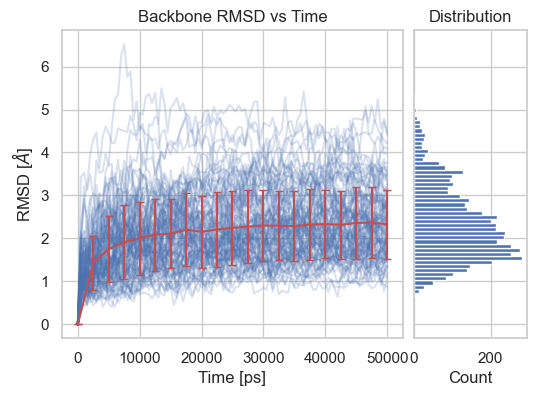

In [237]:
aveR = np.mean(Rmsd,axis=0)
stdR = np.std(Rmsd,axis=0)

fig,ax = plt.subplots(1,2,figsize=(6,4), sharex=False, sharey=True, gridspec_kw={"width_ratios" : [3,1], "wspace" : 0.05})

for R in Rmsd: 
    ax[0].plot(times, R, alpha=0.2, c='b')
ax[0].errorbar(times[::5],aveR[::5],stdR[::5],capsize=3, c='r', label='average')
ax[0].set_xlabel("Time [ps]")
ax[0].set_ylabel("RMSD [$\AA$]")
ax[0].set_title("Backbone RMSD vs Time")
# ax[0].grid(True)

# flatting out list of RMSDs and only looking at the second part of the trajectory
hlen = int(nframes/2)
Rmsd_flat = [i for j in Rmsd for i in j[hlen:]]
# h,b = np.histogram(Rmsd_flat,bins=50)
# ax[1].barh(b[:-1],h,color='b')
ax[1].hist(Rmsd_flat, bins=50, orientation="horizontal")
ax[1].set_xlabel('Count')
# ax[1].grid(True)
ax[1].set_title("Distribution")

# plt.suptitle('Backbone RMSD')
plt.tight_layout()
plt.savefig('../figures/rmsd.png',dpi=150,bbox_inches='tight')

### Radius of Gyration

In [193]:
rgs = []
times = []

for ts in u.trajectory:
    rg_ch = []
    for chain in chains:
        rg = chain.radius_of_gyration()
        rg_ch.append(rg)
    rgs.append(rg_ch)
    times.append(u.trajectory.time)

/var/folders/l3/hpp1fxfn21x5qfv6yd9mfbn80000gn/T/ipykernel_49766/2227168560.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


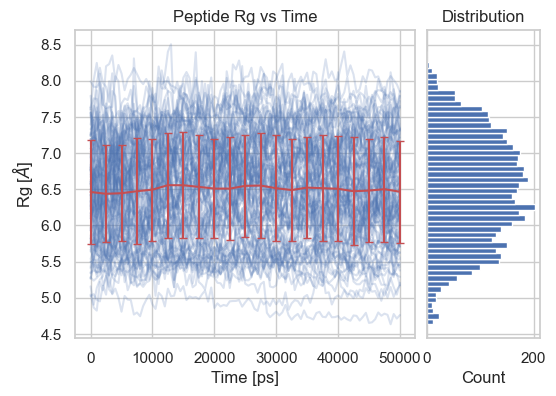

In [238]:
aveRgs = np.mean(rgs,axis=1)
stdRgs = np.std(rgs,axis=1)
fig,ax = plt.subplots(1,2,figsize=(6,4), sharex=False, sharey=True, gridspec_kw={"width_ratios" : [3,1], "wspace" : 0.05})

ax[0].plot(times, rgs, c='b', alpha=0.2)
ax[0].errorbar(times[::5],aveRgs[::5],stdRgs[::5],capsize=3, c='r', label='average')
ax[0].set_xlabel("Time [ps]")
ax[0].set_ylabel("Rg [$\AA$]")
ax[0].set_title("Peptide Rg vs Time")
# ax[0].grid(True)

# flatting out list of RMSDs and only looking at the second part of the trajectory
hlen = int(nframes/2)
Rgs_flat = [i for j in rgs[hlen:] for i in j]
# h,b = np.histogram(Rgs_flat,bins=30)
# ax[1].barh(b[:-1],h,color='b',lw=0,alpha=0.5)
ax[1].hist(Rgs_flat, bins=50, orientation="horizontal")
ax[1].set_xlabel('Count')
ax[1].set_title("Distribution")

plt.tight_layout()
plt.savefig('../figures/gyrate.png',dpi=150,bbox_inches='tight')